# Compute the root mean square (RMS) velocities for a plate implied by a rotation file.

This notebook was developed by Nick Swanson-Hysell and Mike Tetley.

# Import necessary modules

pygplates is a non-standard module that has been developed as part of the open source GPlates project and can be accessed at GPlates.org

In [1]:
import numpy as np
import pygplates as pgp
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

/Users/Laurentia/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The outline of Laurentia and one of the .rot files used in Swanson-Hysell et al. (2015) are included in this repository and used for the example analysis.

In [2]:
cp_polyFile = '1000_Laurentia_outline.gpml'
ref_model_rotfile = 'Kalahari_Laurentia_N_v3.rot'
ref_rotation_model = pgp.RotationModel(ref_model_rotfile)

In [3]:
def generate_uniform_density_points_on_sphere(n):

    # Generate uniform distribution of motion point seeds using Vogel's method
    angle = np.pi * (3 - np.sqrt(5))
    theta = angle * np.arange(n)
    z = np.linspace(1 - 1.0 / n, 1.0 / n - 1, n)
    radius = np.sqrt(1 - z * z)

    points = np.zeros((n, 3))
    points[:,0] = radius * np.cos(theta)
    points[:,1] = radius * np.sin(theta)
    points[:,2] = z

    lons = []
    lats = []

    for i in xrange(0, len(points)):

        point = pgp.convert_point_on_sphere_to_lat_lon_point((points[i][0], points[i][1], points[i][2]))
        lats.append(point.get_latitude())
        lons.append(point.get_longitude())
        
    return lats, lons

In [4]:
def make_GPML_velocity_feature(Long,Lat):
# function to make a velocity mesh nodes at an arbitrary set of points defined in Lat
# Long and Lat are assumed to be 1d arrays. 

    # Add points to a multipoint geometry
    SeedPoints = zip(Lat,Long)
    points = []
    
    for j in range(0,len(SeedPoints)):
        
        points.append(SeedPoints[j])
        
    multi_point = pgp.MultiPointOnSphere(points)

    # Create a feature containing the multipoint feature, and defined as MeshNode type
    meshnode_feature = pgp.Feature(pgp.FeatureType.create_from_qualified_string('gpml:MeshNode'))
    meshnode_feature.set_geometry(multi_point)
    meshnode_feature.set_name('Velocity Mesh Nodes from pygplates')

    output_feature_collection = pgp.FeatureCollection(meshnode_feature)
    
    # NB: at this point, the feature could be written to a file using
    # output_feature_collection.write('myfilename.gpmlz')
    
    # for use within the notebook, the velocity domain feature is returned from the function
    return output_feature_collection

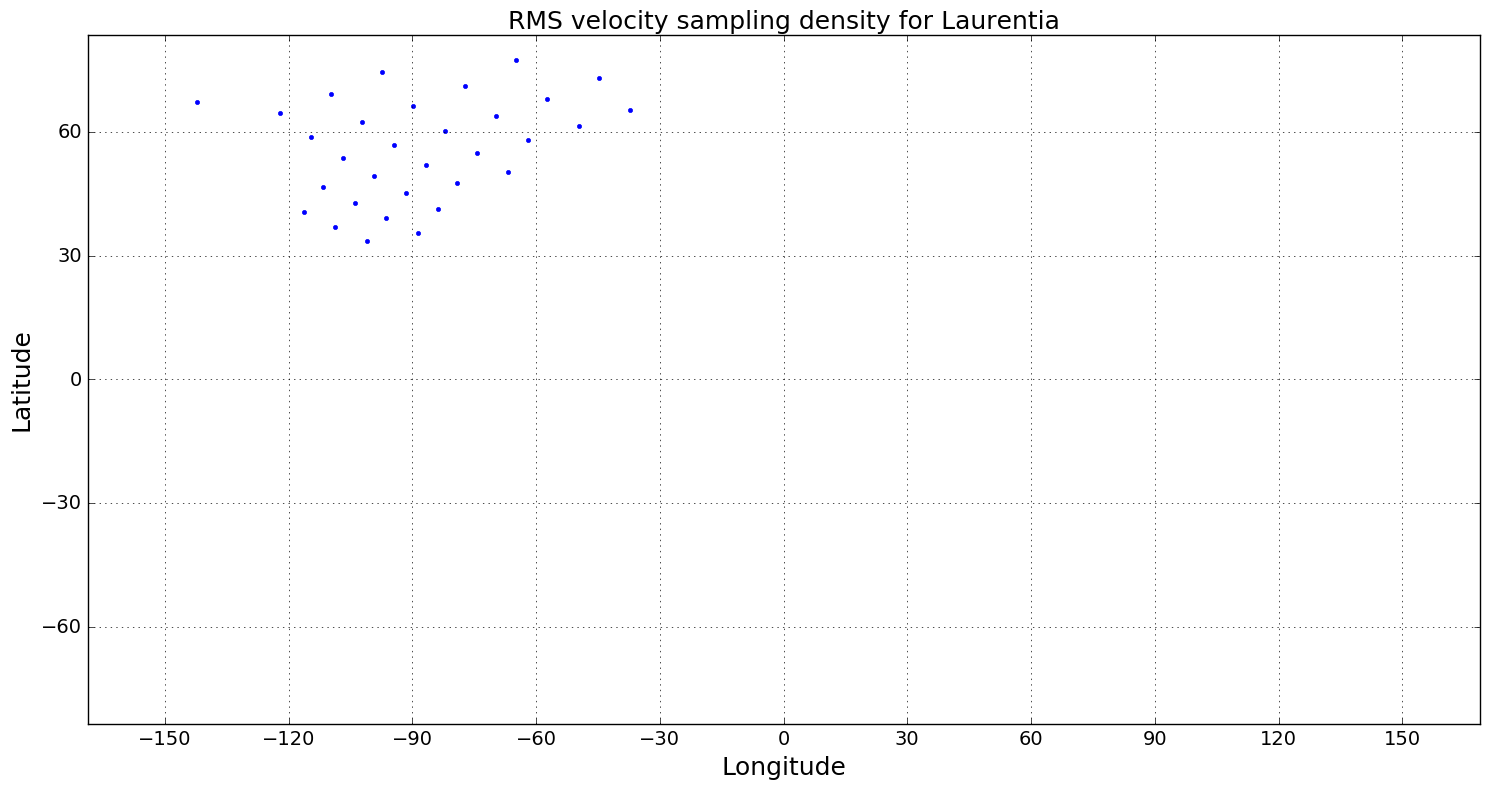

In [5]:
# Generate points on sphere
lats, lons = generate_uniform_density_points_on_sphere(64800/75) #low res
#lats, lons = generate_uniform_density_points_on_sphere(64800/75*2) #med res
#lats, lons = generate_uniform_density_points_on_sphere(64800/75*10) #higher res
#lats, lons = generate_uniform_density_points_on_sphere((64800/75)*100) #high res

# Create GPML velocity feature from points
global_mesh = make_GPML_velocity_feature(lons, lats)    

#plate_ids = [[701, 714, 715], [101], [201], [501], [801], [302], [401], [802]]
#continents = ['Africa', 'North America', 'South America', 'India', 'Australia', 'Baltica', 'Siberia', 
#              'East Antarctica']
plate_ids = [[1000]]
continents = ['Laurentia']
              
# load the features 
cp_featureCollection = pgp.FeatureCollectionFileFormatRegistry()
cp_featureSet = cp_featureCollection.read(cp_polyFile)

lon_lat = []

plt.figure(figsize=(15,8),dpi=300)

for i in xrange(0, len(plate_ids)):

    # make an empty object in which to store the selected features
    selected_features = []
    features_within_selected_plate = []
    lon = []
    lat = []

    for j in xrange(0, len(plate_ids[i])):

        # iterate over every feature in the coastline file, and append the features that match our criteria
        for feature in cp_featureSet:

            if feature.get_reconstruction_plate_id() == plate_ids[i][j]:

                selected_features.append(feature)

        velocity_domain_features = pgp.FeatureCollection(global_mesh)

        # partition features
        partitioned_points = pgp.partition_into_plates(selected_features, ref_rotation_model, velocity_domain_features)

        # Get only the multipoint features that fall within the selected polygon(s)
        #features_within_selected_plate = []

        for feature in partitioned_points:

            if feature.get_reconstruction_plate_id() == plate_ids[i][j]:

                features_within_selected_plate.append(feature)
                

        for feature in features_within_selected_plate:

            for geometry in feature.get_geometries():

                lat.append(geometry.to_lat_lon_array()[:,0])
                lon.append(geometry.to_lat_lon_array()[:,1])
        
        
    lon_lat.append(features_within_selected_plate)

    lon = np.concatenate(lon)
    lat = np.concatenate(lat)

    plt.plot(lon, lat, '.')


    
plt.title('RMS velocity sampling density for Laurentia', fontsize=18)
plt.xlabel("Longitude", fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.axis('equal')
plt.xlim(-180, 180)
plt.ylim(-90, 90)
plt.yticks(np.arange(-90, 91, 30))
plt.xticks(np.arange(-180, 181, 30))

plt.tight_layout()

plt.show()

In [6]:
import pandas as pd

df = pd.DataFrame({'lon':lon, 'lat':lat})
df.to_csv('Laurentia_lon_lat.csv')

In [7]:
plate_id = 1000
rotation_model = ref_rotation_model
model_name = "Swanson-Hysell et al. 2015"

time = 1105
delta_time = 1

velocity_magnitude = []
reconstructed_feature_geometries = []
pgp.reconstruct(lon_lat, rotation_model, reconstructed_feature_geometries, time)
equivalent_stage_rotation = rotation_model.get_rotation(time, plate_id, time + delta_time)


for reconstructed_feature_geometry in reconstructed_feature_geometries: 

    # Calculate a velocity for each reconstructed point over the delta time interval.
    velocity_vector = pgp.calculate_velocities(reconstructed_feature_geometry.get_reconstructed_geometry(),
                                               equivalent_stage_rotation,
                                               delta_time,
                                               pgp.VelocityUnits.cms_per_yr)

    velocity_magnitude_azimuth = pgp.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                                 reconstructed_feature_geometry.get_reconstructed_geometry(),
                                 velocity_vector)
    
    velocity_magnitude_ned = pgp.LocalCartesian.convert_from_geocentric_to_north_east_down(
                                 reconstructed_feature_geometry.get_reconstructed_geometry(),
                                 velocity_vector)

velocity_magnitudes = []
for n in range(0,len(velocity_magnitude_azimuth)):
    velocity_magnitudes.append(velocity_magnitude_azimuth[n][0])
    
RMS_velocity_for_stage = np.sqrt(np.mean(np.square(np.asarray(velocity_magnitudes))))
mean_velocity_for_stage = np.mean(np.asarray(velocity_magnitudes))
print RMS_velocity_for_stage
print mean_velocity_for_stage

27.7805710598
27.7666401982


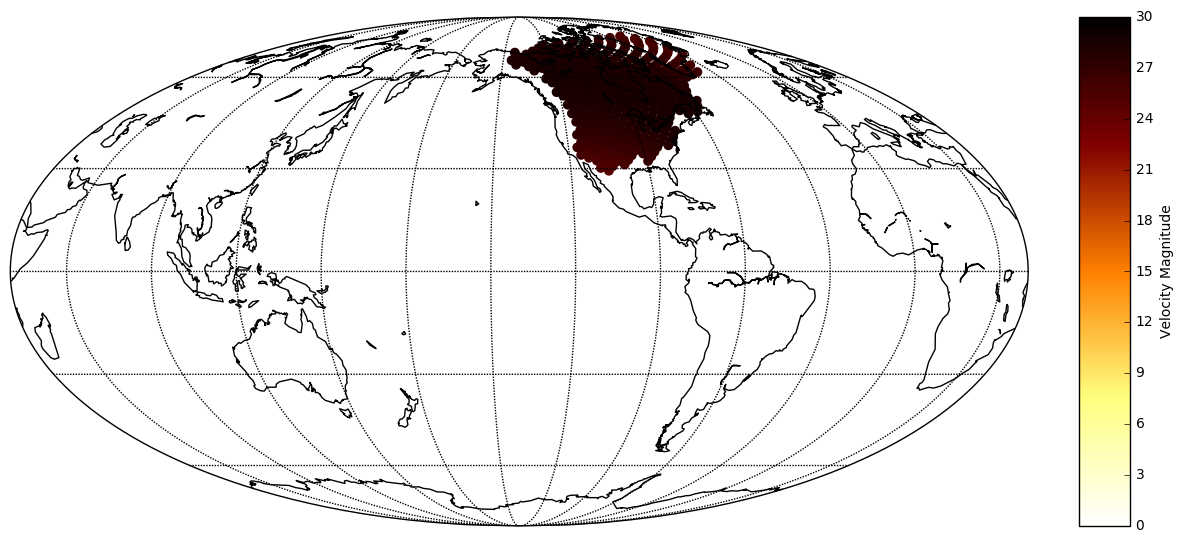

In [8]:
fig = plt.figure(figsize=(14,10),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0])

m = Basemap(projection='moll', lon_0=220, resolution='c', ax=ax_map)
cp = m.drawmapboundary()
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))

x,y = m(lon,lat)
im = m.scatter(x,y,c=velocity_magnitudes,edgecolor='',s=50,
               cmap=plt.cm.afmhot_r,vmin=0,
               vmax=30)

# add colorbar.
cbar = m.colorbar(im,location='right',pad="5%")
cbar.set_label('Velocity Magnitude')

plt.show()

In [9]:
lat_lon_recon = []
pgp.reconstruct(lon_lat, rotation_model, lat_lon_recon, time)

for point in lat_lon_recon:
    lat_lon_reconstructed = point.get_reconstructed_geometry()
lat_lon_list = lat_lon_reconstructed.to_lat_lon_list()

lat_recon = []
lon_recon = []

for n in xrange(0,len(lat_lon_list)):
    lat_recon.append(lat_lon_list[n][0])
    lon_recon.append(lat_lon_list[n][1])

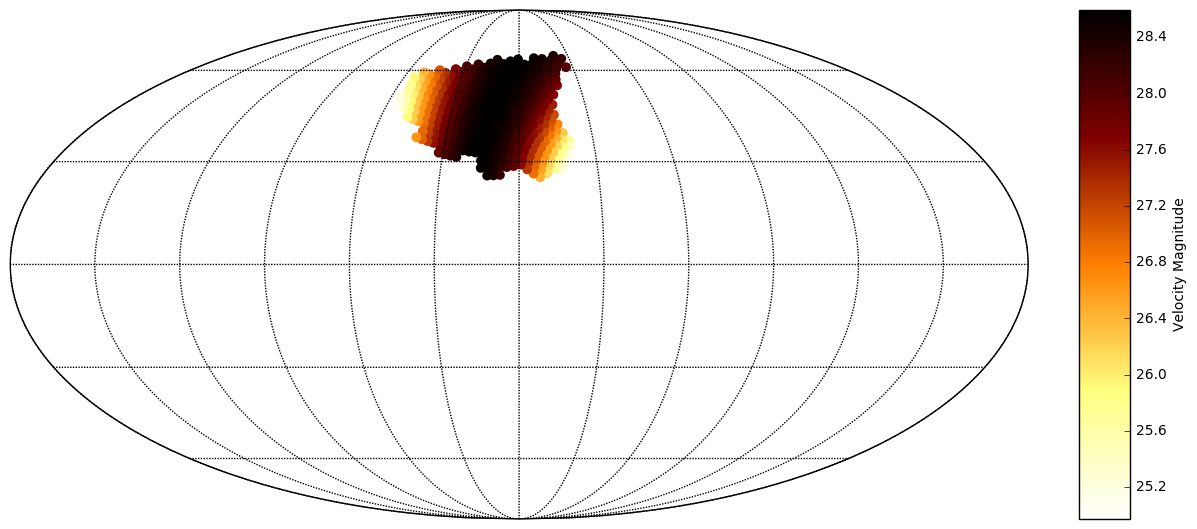

In [10]:
fig = plt.figure(figsize=(14,10),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0])

m = Basemap(projection='moll', lon_0=0, resolution='c', ax=ax_map)
cp = m.drawmapboundary()
#m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))

x,y = m(lon_recon,lat_recon)
im = m.scatter(x,y,c=velocity_magnitudes,edgecolor='',s=50,
               cmap=plt.cm.afmhot_r,vmin=np.min(velocity_magnitudes),
               vmax=np.max(velocity_magnitudes))

# add colorbar.
cbar = m.colorbar(im,location='right',pad="5%")
cbar.set_label('Velocity Magnitude')

plt.show()

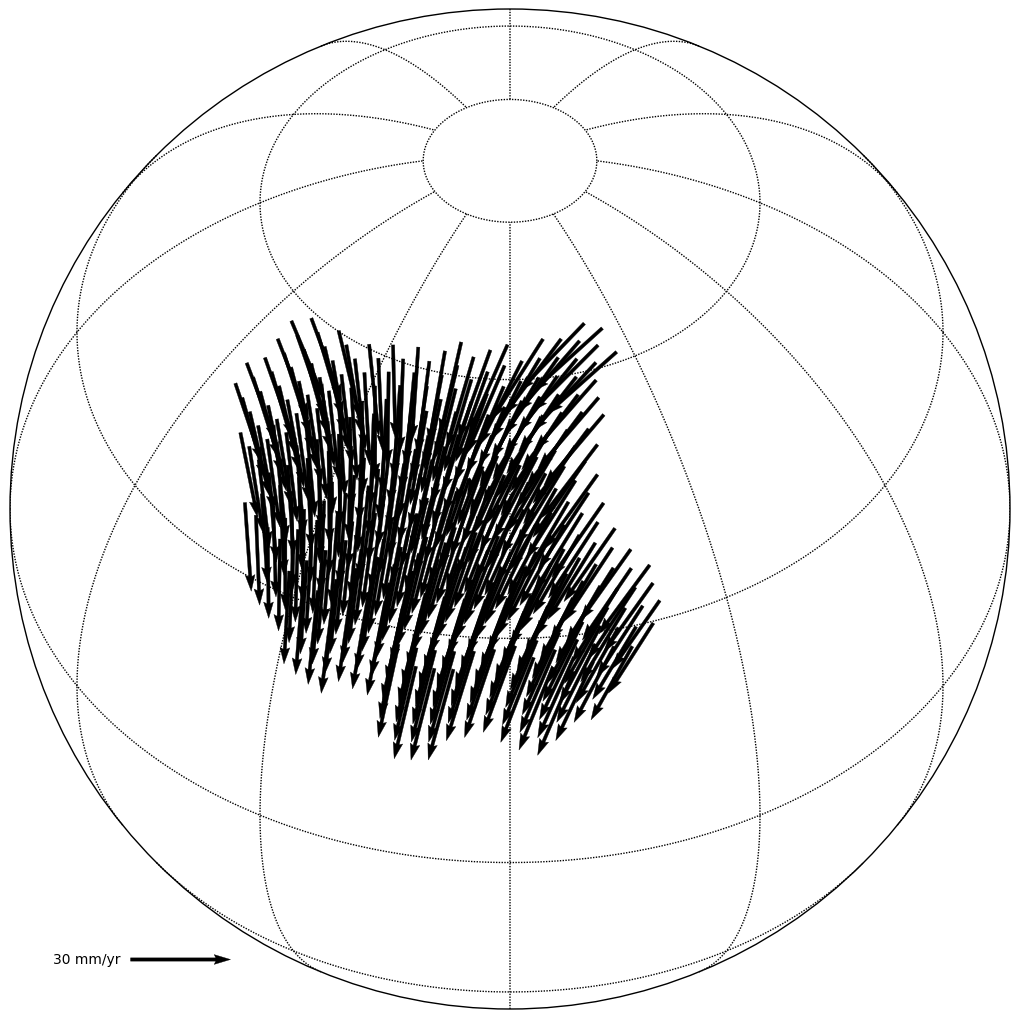

In [11]:
pt_vel_n=[]
pt_vel_e=[]
for vel in velocity_magnitude_ned:
    pt_vel_e.append(vel.get_y())
    pt_vel_n.append(vel.get_x())

fig = plt.figure(figsize=(14,10),dpi=150)
ax_map = fig.add_axes([0,0,0.8,1.0])

m = Basemap(projection='ortho', lon_0=0, lat_0=45, resolution='c', ax=ax_map)
cp = m.drawmapboundary()
#m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))

x,y = m(lon_recon,lat_recon)

#m.quiver(x,y,pt_vel_e,pt_vel_n,scale=200,linewidth=0.4,color='lightblue')
Q = m.quiver(x,y,pt_vel_e,pt_vel_n,scale=300,linewidth=0.25)
# make quiver key.
qk = plt.quiverkey(Q, 0.12, 0.05, 30, '30 mm/yr', labelpos='W')
plt.show()

In [12]:
#velocities = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
#                        [velocity_domain_point],
#                        velocity_vector)

all_velocities = []

for reconstructed_feature_geometry in reconstructed_feature_geometries: 

    # Calculate a velocity for each reconstructed point over the delta time interval.
    velocity_vector = pgp.calculate_velocities(reconstructed_feature_geometry.get_reconstructed_geometry(),
                                               equivalent_stage_rotation,
                                               delta_time,
                                               pgp.VelocityUnits.cms_per_yr)

    velocities = pgp.LocalCartesian.convert_from_geocentric_to_north_east_down(
                                 reconstructed_feature_geometry.get_reconstructed_geometry(),
                                 velocity_vector)
    
    all_velocities.append(velocities[0])

pt_vel_n=[]
pt_vel_e=[]
for vel in all_velocities:
    pt_vel_e.append(vel.get_y())
    pt_vel_n.append(vel.get_x())

print pt_vel_n 
print pt_vel_e 

[-20.67376455480109]
[-15.249519927250248]


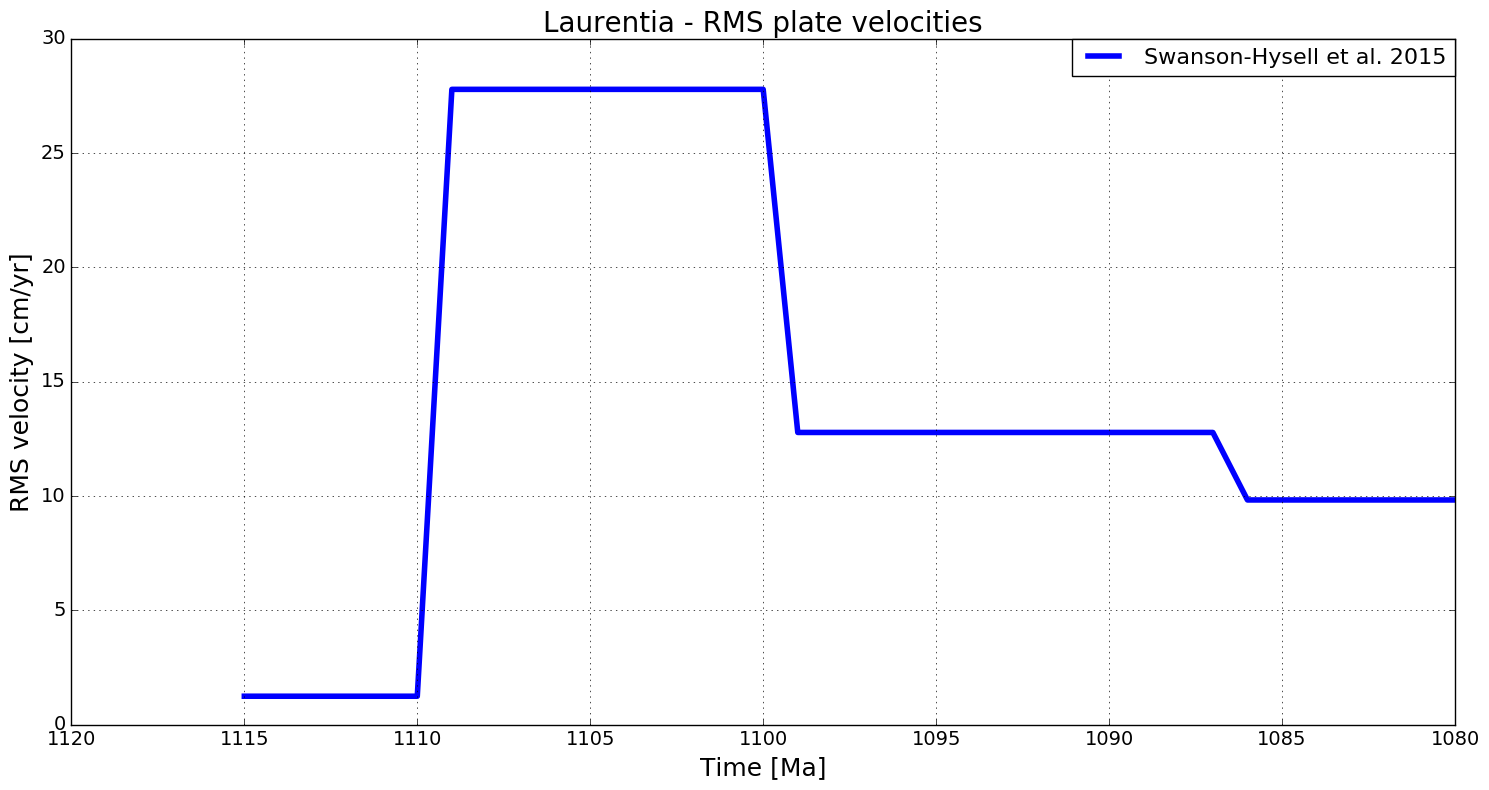

In [13]:
max_time = 1115.0
min_time = 1080.0
delta_time = 1

time_array = np.arange(min_time, max_time + 10, 10)

for ii in xrange(0, len(lon_lat)):
    
    plate_id = plate_ids[ii][0]
    plt.figure(figsize=(15,8),dpi=300)

    RMS_list = []

    rotation_model = ref_rotation_model
    model_name = "Swanson-Hysell et al. 2015"


    for time in np.arange(0, max_time + 1., delta_time):

        velocity_magnitude = []

        # Reconstruct the point features.
        reconstructed_feature_geometries = []
        pgp.reconstruct(lon_lat[ii], rotation_model, reconstructed_feature_geometries, time)

        # Get the rotation from 'time+delta' to 'time', and the feature's reconstruction plate ID.
        equivalent_stage_rotation = rotation_model.get_rotation(time, plate_id, time + delta_time)

        for reconstructed_feature_geometry in reconstructed_feature_geometries: 

            # Calculate a velocity for each reconstructed point over the delta time interval.
            velocity_vector = pgp.calculate_velocities(reconstructed_feature_geometry.get_reconstructed_geometry(),
                                                       equivalent_stage_rotation,
                                                       delta_time,
                                                       pgp.VelocityUnits.cms_per_yr)

            velocity_magnitude_azimuth = pgp.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                                         reconstructed_feature_geometry.get_reconstructed_geometry(),
                                         velocity_vector)
            for n in xrange(0,len(velocity_magnitude_azimuth)):
                velocity_magnitude.append(velocity_magnitude_azimuth[n][0])

        RMS_velocity_for_stage = np.sqrt(np.mean(np.square(np.asarray(velocity_magnitude))))
        RMS_list.append(RMS_velocity_for_stage)

    plt.plot(np.arange(0, max_time + 1., delta_time), RMS_list, linewidth=4, linestyle='solid',
                 label=model_name)

    
    plt.title(continents[ii] + " - RMS plate velocities", fontsize=20)
    plt.xlabel("Time [Ma]", fontsize=18)
    plt.ylabel('RMS velocity [cm/yr]', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.grid()
    #plt.semilogy()
    plt.xlim(time_array[-1], time_array[0])

    lgd = plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0., fontsize=16)
    
    plt.tight_layout()
        
    plt.show()